# Performance Comparison of the TPOT and H2O AutoML Algorithms

## Classification

### Loading data

In [1]:
# Importing dependencies
import tpot
from tpot import TPOTClassifier, TPOTRegressor
import sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split

# Loading a dataset for training
data = datasets.load_breast_cancer()

# Splitting our data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data["data"], 
                                                    data["target"], 
                                                    test_size=0.2, 
                                                    stratify=data["target"])

### Classification in 3 minutes (no early stopping)

#### TPOT classification performance in 3 minutes

In [2]:
# Function for creating a TPOT optimizer
def create_tpot_optimizer(mode, 
                          max_time_mins, 
                          generations=None, 
                          population_size=100,
                          offspring_size=100,                           
                          early_stop=None, 
                          template=None):    
    # TPOT classifier
    if mode == "classification":
        optimizer = TPOTClassifier(generations=generations,
                                   population_size=population_size,
                                   offspring_size=offspring_size,
                                   random_state=1,
                                   max_time_mins=max_time_mins,
                                   scoring="roc_auc",
                                   verbosity=2,
                                   early_stop=early_stop,
                                   template=template,
                                   use_dask=True,
                                   n_jobs=-1)
    # TPOT regressor
    elif mode == "regression":        
        optimizer = TPOTRegressor(generations=generations,
                                  population_size=population_size,
                                  offspring_size=offspring_size,
                                  random_state=1,
                                  max_time_mins=max_time_mins,
                                  scoring="neg_root_mean_squared_error",
                                  verbosity=2,
                                  early_stop=early_stop,                                  
                                  template=template,
                                  use_dask=True,
                                  n_jobs=-1)
        
    return optimizer

In [3]:
# Insantiating our TPOT pipeline optimizer
pipeline_optimizer = create_tpot_optimizer(mode="classification", 
                                           max_time_mins=3)

In [4]:
# Function for training and evaluating the TPOT optimizer
def train_eval_tpot(optimizer, 
                    train_features, train_labels, 
                    test_features, test_labels):
    # Fitting the optimizer
    optimizer.fit(train_features, 
                  train_labels)
    
    # Obtaining the best pipeline
    best_pipeline = optimizer.fitted_pipeline_
    
    # Evaluating performance on the test set
    score = pipeline_optimizer.score(test_features, 
                                     test_labels)
    
    return best_pipeline, score    

In [5]:
%%time

# Running the TPOT pipeline optimizer and tracking time
fitted_pipeline, tpot_score = train_eval_tpot(pipeline_optimizer, 
                                              X_train, y_train, 
                                              X_test, y_test)

# Viewing the best model and test AUC
print("\n### BEST PIPELINE ###\n"
      f"{fitted_pipeline}")
print(f"\nTest AUC achieved with TPOT in 3 minutes: {tpot_score:.5f}\n")

Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9961816305469556

Generation 2 - Current best internal CV score: 0.9966976264189886

Generation 3 - Current best internal CV score: 0.9966976264189886

3.85 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: SGDClassifier(XGBClassifier(PCA(RobustScaler(input_matrix), iterated_power=3, svd_solver=randomized), learning_rate=0.5, max_depth=6, min_child_weight=5, n_estimators=100, n_jobs=1, subsample=0.3, verbosity=0), alpha=0.0, eta0=0.01, fit_intercept=True, l1_ratio=0.0, learning_rate=invscaling, loss=squared_hinge, penalty=elasticnet, power_t=0.5)

### BEST PIPELINE ###
Pipeline(steps=[('robustscaler', RobustScaler()),
                ('pca',
                 PCA(iterated_power=3, random_state=1,
                     svd_solver='randomized')),
                ('stackingestimator',
                 StackingEstimator(es

#### H2O classification performance in 3 minutes

In [6]:
# Importing dependencies
import h2o
from h2o.automl import H2OAutoML
from sklearn import datasets
from sklearn.model_selection import train_test_split

# Initializing our H2O cluster
h2o.init(name="h2ocluster", nthreads=12)

# Creating H2OFrame objects for train data
train_features = h2o.H2OFrame(X_train, column_names=list(data["feature_names"]))
train_labels = h2o.H2OFrame(y_train, column_names=["target"])

# Creating H2OFrame objects for test data
test_features = h2o.H2OFrame(X_test, column_names=list(data["feature_names"]))
test_labels = h2o.H2OFrame(y_test, column_names=["target"])

# Joining our features and labels
train_frame = train_features.cbind(train_labels)
test_frame = test_features.cbind(test_labels)    

# Specifying feature and target names for training
x = train_frame.columns
y = "target"
x.remove(y)

# Converting labels to categoricals
train_frame[y] = train_frame[y].asfactor()
test_frame[y] = test_frame[y].asfactor()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.311-b11, mixed mode)
  Starting server from C:\Users\tigra\AppData\Local\Programs\Python\Python39\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\tigra\AppData\Local\Temp\tmphkgbo9v0
  JVM stdout: C:\Users\tigra\AppData\Local\Temp\tmphkgbo9v0\h2o_tigra_started_from_python.out
  JVM stderr: C:\Users\tigra\AppData\Local\Temp\tmphkgbo9v0\h2o_tigra_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Asia/Yerevan
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.7
H2O_cluster_version_age:,1 month and 27 days
H2O_cluster_name:,h2ocluster
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.545 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [7]:
# Function for creating H2O AutoML
def create_h2o_automl(mode, 
                      max_runtime_secs, 
                      max_models=None, 
                      stopping_rounds=0):
    # Selecting a sorting metric based on task
    if mode == "classification":
        sort_metric = "AUC"
    elif mode == "regression":
        sort_metric = "RMSE"
    
    # Instantiating an H2O AutoML object
    aml = H2OAutoML(seed=1, 
                    max_runtime_secs=max_runtime_secs, 
                    max_models=max_models, 
                    verbosity="info", 
                    stopping_rounds=stopping_rounds, 
                    sort_metric=sort_metric)
        
    return aml

In [8]:
# Instantiating H2OAutoML
aml = create_h2o_automl(mode="classification", 
                        max_runtime_secs=180)

In [9]:
# Function for training and evaluating H2OAutoML
def train_eval_h2o(automl, 
                   x, y, 
                   train_frame, 
                   test_frame):
    automl.train(x=x, y=y, 
                 training_frame=train_frame)
    
    lb = aml.leaderboard
    score = automl.leader.model_performance(test_frame)
    
    return lb, score

In [10]:
%%time

# Running H2OAutoML and tracking time
lb, h2o_score = train_eval_h2o(aml, 
                               x, y, 
                               train_frame, 
                               test_frame)

# Viewing the leaderboard and test AUC
print("\n### EVALUATED MODELS ###\n"
      f"{lb}")
print(f"\nTest AUC achieved with H2O in 3 minutes: {h2o_score.auc():.5f}\n")

AutoML progress: |
13:40:10.394: Project: AutoML_20211030_134010392
13:40:10.395: Setting stopping tolerance adaptively based on the training frame: 0.04688072309384954
13:40:10.395: Build control seed: 1
13:40:10.396: training frame: Frame key: automl_training_py_2_sid_a366    cols: 31    rows: 455  chunks: 1    size: 40509  checksum: -6133975878204427307
13:40:10.396: validation frame: NULL
13:40:10.396: leaderboard frame: NULL
13:40:10.396: blending frame: NULL
13:40:10.396: response column: target
13:40:10.396: fold column: null
13:40:10.396: weights column: null
13:40:10.406: AutoML: XGBoost is not available; skipping it.
13:40:10.409: Loading execution steps: [{XGBoost : defaults}, {GLM : defaults}, {DRF : [def_1]}, {GBM : defaults}, {DeepLearning : defaults}, {DRF : [XRT]}, {XGBoost : grids}, {GBM : grids}, {DeepLearning : grids}, {GBM : [lr_annealing]}, {XGBoost : [lr_search]}, {StackedEnsemble : defaults}]
13:40:10.418: Disabling Algo: XGBoost as requested by the user.
13:40:1

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
DeepLearning_grid__3_AutoML_20211030_134010_model_2,0.997028,0.130591,0.998167,0.024097,0.160216,0.0256693
StackedEnsemble_BestOfFamily_AutoML_20211030_134010,0.996801,0.0661771,0.998003,0.0287926,0.136461,0.0186216
GLM_1_AutoML_20211030_134010,0.995707,0.0797195,0.997352,0.0270382,0.149829,0.0224487
DeepLearning_grid__1_AutoML_20211030_134010_model_4,0.995645,0.114604,0.997293,0.0287926,0.150588,0.0226767
DeepLearning_grid__1_AutoML_20211030_134010_model_6,0.995562,0.097183,0.997284,0.0287926,0.151649,0.0229974
DeepLearning_grid__2_AutoML_20211030_134010_model_4,0.995521,0.102668,0.997213,0.0234778,0.147488,0.0217526
DeepLearning_grid__2_AutoML_20211030_134010_model_5,0.995397,0.215562,0.997168,0.0352941,0.18196,0.0331095
StackedEnsemble_AllModels_AutoML_20211030_134010,0.995377,0.118166,0.996856,0.0211558,0.150383,0.0226152
DeepLearning_grid__3_AutoML_20211030_134010_model_5,0.995253,0.235622,0.997146,0.0276058,0.168352,0.0283423
DeepLearning_grid__1_AutoML_20211030_134010_model_1,0.995212,0.112283,0.997085,0.0317337,0.16126,0.0260048



### EVALUATED MODELS ###


Test AUC achieved with H2O in 3 minutes: 0.98115

Wall time: 2min 36s


#### TPOT classification performance in 3 minutes with a classifier only

In [11]:
# Insantiating our TPOT pipeline optimizer
pipeline_optimizer = create_tpot_optimizer(mode="classification", 
                                           max_time_mins=3, 
                                           template="Classifier")

In [12]:
%%time

# Running the TPOT pipeline optimizer and tracking time
fitted_pipeline, tpot_score = train_eval_tpot(pipeline_optimizer, 
                                              X_train, y_train, 
                                              X_test, y_test)

# Running the TPOT pipeline optimizer and tracking time
print("\n### BEST PIPELINE ### \n"
      f"{fitted_pipeline}")
print(f"\nTest AUC achieved with TPOT (classifier only) in 3 minutes: {tpot_score:.5f}\n")

Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9959752321981424

Generation 2 - Current best internal CV score: 0.9959752321981424

Generation 3 - Current best internal CV score: 0.9964912280701755

Generation 4 - Current best internal CV score: 0.9964912280701755

3.42 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: GradientBoostingClassifier(input_matrix, learning_rate=0.5, max_depth=10, max_features=0.2, min_samples_leaf=18, min_samples_split=9, n_estimators=100, subsample=0.6500000000000001)

### BEST PIPELINE ### 
Pipeline(steps=[('gradientboostingclassifier',
                 GradientBoostingClassifier(learning_rate=0.5, max_depth=10,
                                            max_features=0.2,
                                            min_samples_leaf=18,
                                            min_samples_split=9, random_state=1,
                

### Classification with early stopping (within 60 minutes)

#### TPOT classification performance with early stopping

In [13]:
# Insantiating our TPOT pipeline optimizer
pipeline_optimizer = create_tpot_optimizer(mode="classification", 
                                           max_time_mins=60, 
                                           early_stop=2)

In [14]:
%%time

# Running the TPOT pipeline optimizer and tracking time
fitted_pipeline, tpot_score = train_eval_tpot(pipeline_optimizer, 
                                              X_train, y_train, 
                                              X_test, y_test)

# Viewing the best pipeline and test AUC
print("\n### BEST PIPELINE ###\n"
      f"{fitted_pipeline}")
print(f"\nTest AUC achieved with TPOT with early stopping: {tpot_score:.5f}\n")

Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9961816305469556

Generation 2 - Current best internal CV score: 0.9961816305469556

Generation 3 - Current best internal CV score: 0.9961816305469556

Generation 4 - Current best internal CV score: 0.9961816305469556

Generation 5 - Current best internal CV score: 0.9969040247678018

Generation 6 - Current best internal CV score: 0.9969040247678018

Generation 7 - Current best internal CV score: 0.9969040247678018

Generation 8 - Current best internal CV score: 0.9969040247678018

The optimized pipeline was not improved after evaluating 2 more generations. Will end the optimization process.

TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: GradientBoostingClassifier(PolynomialFeatures(SelectFwe(input_matrix, alpha=0.016), degree=2, include_bias=False, interaction_only=False), learning_rate=0.5, max_depth=10, max_features=0.1, min_samples_leaf=9, min_samples_split=15, n_estimators=100, subsample=0.60000000000

#### H2O classification performance with early stopping

In [15]:
# Instantiating H2OAutoML
aml = create_h2o_automl(mode="classification", 
                        max_runtime_secs=3600, 
                        stopping_rounds=2)

In [16]:
%%time

# Running H2OAutoML and tracking time
lb, h2o_score = train_eval_h2o(aml, 
                               x, y, 
                               train_frame, 
                               test_frame)

# Viewing the leaderboard and test AUC
print("\n### EVALUATED MODELS###\n"
      f"{lb}")
print(f"\nTest AUC achieved with H2O with early stopping: {h2o_score.auc():.5f}\n")

AutoML progress: |
13:56:31.827: Project: AutoML_20211030_135631827
13:56:31.827: Setting stopping tolerance adaptively based on the training frame: 0.04688072309384954
13:56:31.827: Build control seed: 1
13:56:31.828: training frame: Frame key: automl_training_py_2_sid_a366    cols: 31    rows: 455  chunks: 1    size: 40509  checksum: -6133975878204427307
13:56:31.828: validation frame: NULL
13:56:31.828: leaderboard frame: NULL
13:56:31.828: blending frame: NULL
13:56:31.828: response column: target
13:56:31.828: fold column: null
13:56:31.828: weights column: null
13:56:31.828: AutoML: XGBoost is not available; skipping it.
13:56:31.828: Loading execution steps: [{XGBoost : defaults}, {GLM : defaults}, {DRF : [def_1]}, {GBM : defaults}, {DeepLearning : defaults}, {DRF : [XRT]}, {XGBoost : grids}, {GBM : grids}, {DeepLearning : grids}, {GBM : [lr_annealing]}, {XGBoost : [lr_search]}, {StackedEnsemble : defaults}]
13:56:31.828: Disabling Algo: XGBoost as requested by the user.
13:56:3

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
DeepLearning_grid__3_AutoML_20211030_135631_model_5,0.998039,0.183934,0.998841,0.0311662,0.161795,0.0261778
DeepLearning_grid__1_AutoML_20211030_135631_model_5,0.997688,0.0887074,0.998577,0.0223426,0.130215,0.0169559
DeepLearning_grid__3_AutoML_20211030_135631_model_2,0.997606,0.134239,0.998485,0.0223426,0.152638,0.0232984
DeepLearning_grid__3_AutoML_20211030_135631_model_13,0.997523,0.0873904,0.998489,0.028225,0.137333,0.0188602
DeepLearning_grid__1_AutoML_20211030_135631_model_3,0.997358,0.0852285,0.998381,0.0217234,0.135887,0.0184653
StackedEnsemble_BestOfFamily_AutoML_20211030_135631,0.997276,0.0703501,0.998357,0.0287926,0.143069,0.0204688
DeepLearning_grid__3_AutoML_20211030_135631_model_63,0.997234,0.17553,0.998323,0.0276058,0.159313,0.0253807
DeepLearning_grid__1_AutoML_20211030_135631_model_7,0.997049,0.111452,0.998231,0.0299794,0.162051,0.0262605
DeepLearning_grid__3_AutoML_20211030_135631_model_43,0.997049,0.0635564,0.998166,0.0211558,0.133298,0.0177685
StackedEnsemble_AllModels_AutoML_20211030_135631,0.997049,0.112054,0.998182,0.0205366,0.146002,0.0213167



### EVALUATED MODELS###


Test AUC achieved with H2O with early stopping: 0.98280

Wall time: 30min 53s


#### TPOT classification performance with early stopping (classifier only)

In [17]:
# Insantiating our TPOT pipeline optimizer
pipeline_optimizer = create_tpot_optimizer(mode="classification", 
                                           max_time_mins=60, 
                                           early_stop=2, 
                                           template="Classifier")

In [18]:
%%time

# Running the TPOT pipeline optimizer and tracking time
fitted_pipeline, tpot_score = train_eval_tpot(pipeline_optimizer, 
                                              X_train, y_train, 
                                              X_test, y_test)

# Viewing the best pipeline and test AUC
print("\n### BEST PIPELINE ### \n"
      f"{fitted_pipeline}")
print(f"\nTest AUC achieved with TPOT with early stopping & classifier only: {tpot_score:.5f}\n")

Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9959752321981424

Generation 2 - Current best internal CV score: 0.9959752321981424

Generation 3 - Current best internal CV score: 0.9959752321981424

The optimized pipeline was not improved after evaluating 2 more generations. Will end the optimization process.

TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: GradientBoostingClassifier(input_matrix, learning_rate=1.0, max_depth=10, max_features=0.2, min_samples_leaf=18, min_samples_split=9, n_estimators=100, subsample=0.6500000000000001)

### BEST PIPELINE ### 
Pipeline(steps=[('gradientboostingclassifier',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=10,
                                            max_features=0.2,
                                            min_samples_leaf=18,
                                            min_samples_split=9, random_state=1,
                                            subsample=0.65000000000000

### Classification with 50 models/pipelines

#### TPOT classification with 50 pipelines

In [19]:
# Insantiating our TPOT pipeline optimizer
pipeline_optimizer = create_tpot_optimizer(mode="classification", 
                                           max_time_mins=None, 
                                           generations=4,
                                           population_size=10, 
                                           offspring_size=10)

In [20]:
%%time

# Running the TPOT pipeline optimizer and tracking time
fitted_pipeline, tpot_score = train_eval_tpot(pipeline_optimizer, 
                                              X_train, y_train, 
                                              X_test, y_test)

# Viewing the best pipeline and test AUC
print("\n### BEST PIPELINE ###\n"
      f"{fitted_pipeline}")
print(f"\nTest AUC achieved with TPOT after training 30 pipelines: {tpot_score:.5f}\n")

Optimization Progress:   0%|          | 0/50 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9961816305469556

Generation 2 - Current best internal CV score: 0.9961816305469556

Generation 3 - Current best internal CV score: 0.9962848297213622

Generation 4 - Current best internal CV score: 0.9962848297213622

Best pipeline: MLPClassifier(StandardScaler(input_matrix), alpha=0.001, learning_rate_init=0.001)

### BEST PIPELINE ###
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpclassifier', MLPClassifier(alpha=0.001, random_state=1))])

Test AUC achieved with TPOT after training 30 pipelines: 0.98743

Wall time: 33.9 s


#### H2O classification with 50 models

In [21]:
# Instantiating H2OAutoML
aml = create_h2o_automl(mode="classification", 
                        max_runtime_secs=0, 
                        max_models=50)

In [22]:
%%time

# Running H2OAutoML and tracking time
lb, h2o_score = train_eval_h2o(aml, 
                               x, y, 
                               train_frame, test_frame)

# Viewing the leaderboard and test AUC
print("\n### EVALUATED MODELS ###\n"
      f"{lb}")
print(f"\nTest AUC achieved with H2O with 50 models: {h2o_score.auc():.5f}\n")

AutoML progress: |
14:30:29.711: Project: AutoML_20211030_143029711
14:30:29.711: Setting stopping tolerance adaptively based on the training frame: 0.04688072309384954
14:30:29.711: Build control seed: 1
14:30:29.712: training frame: Frame key: automl_training_py_2_sid_a366    cols: 31    rows: 455  chunks: 1    size: 40509  checksum: -6133975878204427307
14:30:29.712: validation frame: NULL
14:30:29.712: leaderboard frame: NULL
14:30:29.712: blending frame: NULL
14:30:29.712: response column: target
14:30:29.712: fold column: null
14:30:29.712: weights column: null
14:30:29.712: AutoML: XGBoost is not available; skipping it.
14:30:29.712: Loading execution steps: [{XGBoost : defaults}, {GLM : defaults}, {DRF : [def_1]}, {GBM : defaults}, {DeepLearning : defaults}, {DRF : [XRT]}, {XGBoost : grids}, {GBM : grids}, {DeepLearning : grids}, {GBM : [lr_annealing]}, {XGBoost : [lr_search]}, {StackedEnsemble : defaults}]
14:30:29.712: Disabling Algo: XGBoost as requested by the user.
14:30:2

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
DeepLearning_grid__3_AutoML_20211030_143029_model_6,0.99773,0.0886262,0.998593,0.0187822,0.134122,0.0179887
StackedEnsemble_BestOfFamily_AutoML_20211030_143029,0.99709,0.06166,0.998172,0.019969,0.129212,0.0166958
DeepLearning_grid__3_AutoML_20211030_143029_model_1,0.996718,0.0733066,0.997941,0.0187822,0.130617,0.0170608
DeepLearning_grid__1_AutoML_20211030_143029_model_4,0.996594,0.0853173,0.997947,0.030547,0.151927,0.0230819
DeepLearning_grid__3_AutoML_20211030_143029_model_5,0.996471,0.119963,0.997858,0.0329205,0.164947,0.0272075
DeepLearning_grid__2_AutoML_20211030_143029_model_3,0.996388,0.0859648,0.997822,0.026419,0.156138,0.0243791
DeepLearning_grid__1_AutoML_20211030_143029_model_7,0.996326,0.0851415,0.99774,0.0299794,0.146556,0.0214787
DeepLearning_grid__3_AutoML_20211030_143029_model_4,0.995893,0.0922627,0.997412,0.0311662,0.158266,0.0250482
DeepLearning_grid__1_AutoML_20211030_143029_model_5,0.995851,0.0789127,0.997338,0.0229102,0.134765,0.0181617
DeepLearning_grid__2_AutoML_20211030_143029_model_4,0.995707,0.122021,0.997304,0.0270382,0.159867,0.0255576



### EVALUATED MODELS ###


Test AUC achieved with H2O with 50 models: 0.99074

Wall time: 1h 6min 45s


#### TPOT classification with 50 pipelines (classifier only)

In [23]:
# Insantiating our TPOT pipeline optimizer
pipeline_optimizer = create_tpot_optimizer(mode="classification", 
                                           max_time_mins=None, 
                                           generations=4,
                                           population_size=10, 
                                           offspring_size=10,
                                           template="Classifier")

In [24]:
%%time

# Running the TPOT pipeline optimizer and tracking time
fitted_pipeline, tpot_score = train_eval_tpot(pipeline_optimizer, 
                                              X_train, y_train, 
                                              X_test, y_test)

# Viewing the best pipeline and test AUC
print("\n### BEST PIPELINE ###\n"
      f"{fitted_pipeline}")
print(f"\nTest AUC achieved with TPOT after training 50 pipelines (classifier only): {tpot_score:.5f}\n")

Optimization Progress:   0%|          | 0/50 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9928792569659443

Generation 2 - Current best internal CV score: 0.9928792569659443

Generation 3 - Current best internal CV score: 0.9928792569659443

Generation 4 - Current best internal CV score: 0.9946336429308567

Best pipeline: GradientBoostingClassifier(input_matrix, learning_rate=1.0, max_depth=1, max_features=0.9500000000000001, min_samples_leaf=18, min_samples_split=7, n_estimators=100, subsample=1.0)

### BEST PIPELINE ###
Pipeline(steps=[('gradientboostingclassifier',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=1,
                                            max_features=0.9500000000000001,
                                            min_samples_leaf=18,
                                            min_samples_split=7,
                                            random_state=1))])

Test AUC achieved with TPOT after training 50 pipelines (classifier only): 0.99570

Wall time: 22.8 s


## Regression

In [25]:
# Loading a dataset for training
data = datasets.load_diabetes()

# Splitting our data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data["data"], 
                                                    data["target"], 
                                                    test_size=0.2)

### Regression in 3 minutes

#### TPOT regression performance in 3 minutes

In [26]:
# Insantiating our TPOT pipeline optimizer
pipeline_optimizer = create_tpot_optimizer(mode="regression", 
                                           max_time_mins=3)

In [27]:
%%time

# Running the TPOT pipeline optimizer and tracking time
fitted_pipeline, tpot_score = train_eval_tpot(pipeline_optimizer, 
                                              X_train, y_train, 
                                              X_test, y_test)

# Viewing the best pipeline and test RMSE
print("\n### BEST PIPELINE ###\n"
      f"{fitted_pipeline}")
print(f"\nTest RMSE achieved with TPOT in 3 minutes: {tpot_score:.5f}\n")

Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -53.781138158991475

Generation 2 - Current best internal CV score: -53.781138158991475

Generation 3 - Current best internal CV score: -53.46244851014539

Generation 4 - Current best internal CV score: -53.46244851014539

3.45 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: RidgeCV(ExtraTreesRegressor(input_matrix, bootstrap=False, max_features=0.05, min_samples_leaf=16, min_samples_split=2, n_estimators=100))

### BEST PIPELINE ###
Pipeline(steps=[('stackingestimator',
                 StackingEstimator(estimator=ExtraTreesRegressor(max_features=0.05,
                                                                 min_samples_leaf=16,
                                                                 random_state=1))),
                ('ridgecv', RidgeCV(alphas=array([ 0.1,  1. , 10. ])))])

Test RMSE achieved with 

#### H2O regression performance in 3 minutes

In [28]:
# Creating H2OFrame objects for train data
train_features = h2o.H2OFrame(X_train, column_names=list(data["feature_names"]))
train_labels = h2o.H2OFrame(y_train, column_names=["target"])

# Creating H2OFrame objects for test data
test_features = h2o.H2OFrame(X_test, column_names=list(data["feature_names"]))
test_labels = h2o.H2OFrame(y_test, column_names=["target"])

# Joining our features and labels
train_frame = train_features.cbind(train_labels)
test_frame = test_features.cbind(test_labels)    

# Specifying feature and target names for training
x = train_frame.columns
y = "target"
x.remove(y)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [29]:
# Instantiating H2OAutoML
aml = create_h2o_automl(mode="regression", 
                        max_runtime_secs=180)

In [30]:
%%time

# Running H2OAutoML and tracking time
lb, h2o_score = train_eval_h2o(aml, 
                               x, y, 
                               train_frame, 
                               test_frame)

# Viewing the leaderboard and test RMSE
print("\n### EVALUATED MODELS ###\n"
      f"{lb}")
print(f"\nTest RMSE achieved with H2O in 3 minutes: {h2o_score.rmse():.5f}\n")

AutoML progress: |
15:41:06.379: Project: AutoML_20211030_154106379
15:41:06.379: Setting stopping tolerance adaptively based on the training frame: 0.05
15:41:06.379: Build control seed: 1
15:41:06.379: training frame: Frame key: automl_training_py_955_sid_a366    cols: 11    rows: 353  chunks: 1    size: 16848  checksum: 1740449725010309004
15:41:06.379: validation frame: NULL
15:41:06.379: leaderboard frame: NULL
15:41:06.379: blending frame: NULL
15:41:06.379: response column: target
15:41:06.379: fold column: null
15:41:06.379: weights column: null
15:41:06.379: AutoML: XGBoost is not available; skipping it.
15:41:06.379: Loading execution steps: [{XGBoost : defaults}, {GLM : defaults}, {DRF : [def_1]}, {GBM : defaults}, {DeepLearning : defaults}, {DRF : [XRT]}, {XGBoost : grids}, {GBM : grids}, {DeepLearning : grids}, {GBM : [lr_annealing]}, {XGBoost : [lr_search]}, {StackedEnsemble : defaults}]
15:41:06.380: Disabling Algo: XGBoost as requested by the user.
15:41:06.380: AutoML 

model_id,rmse,mean_residual_deviance,mse,mae,rmsle
DeepLearning_grid__1_AutoML_20211030_154106_model_4,53.141,2823.96,2823.96,42.586,0.399328
StackedEnsemble_BestOfFamily_AutoML_20211030_154106,53.3127,2842.24,2842.24,43.1579,0.400077
GLM_1_AutoML_20211030_154106,53.6169,2874.77,2874.77,43.284,0.405449
DeepLearning_grid__1_AutoML_20211030_154106_model_6,53.6321,2876.4,2876.4,43.1145,0.402251
StackedEnsemble_AllModels_AutoML_20211030_154106,53.9704,2912.8,2912.8,44.0027,0.407091
DeepLearning_grid__1_AutoML_20211030_154106_model_1,54.273,2945.56,2945.56,42.6679,0.404643
DeepLearning_1_AutoML_20211030_154106,54.2927,2947.7,2947.7,42.7347,0.408003
DeepLearning_grid__2_AutoML_20211030_154106_model_6,55.6261,3094.26,3094.26,45.5819,0.419283
DRF_1_AutoML_20211030_154106,55.822,3116.09,3116.09,45.7768,0.418427
GBM_grid__1_AutoML_20211030_154106_model_4,56.3989,3180.83,3180.83,45.4236,0.419298



### EVALUATED MODELS ###


Test RMSE achieved with H2O in 3 minutes: 60.84195

Wall time: 2min 36s


#### TPOT regression performance in 3 minutes with a regressor only

In [31]:
# Insantiating our TPOT pipeline optimizer
pipeline_optimizer = create_tpot_optimizer(mode="regression", 
                                           max_time_mins=3, 
                                           template="Regressor")

In [32]:
%%time

# Running the TPOT pipeline optimizer and tracking time
fitted_pipeline, tpot_score = train_eval_tpot(pipeline_optimizer, 
                                              X_train, y_train, 
                                              X_test, y_test)

# Viewing the best pipeline and test RMSE
print("\n### BEST PIPELINE ###\n"
      f"{fitted_pipeline}")
print(f"\nTest RMSE achieved with TPOT (regressor only) in 3 minutes: {tpot_score:.5f}\n")

Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -53.94699579967179

Generation 2 - Current best internal CV score: -53.94699579967179

Generation 3 - Current best internal CV score: -53.94699579967179

Generation 4 - Current best internal CV score: -53.93427934248267

3.36 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: LinearSVR(input_matrix, C=15.0, dual=True, epsilon=0.0001, loss=squared_epsilon_insensitive, tol=0.01)

### BEST PIPELINE ###
Pipeline(steps=[('linearsvr',
                 LinearSVR(C=15.0, epsilon=0.0001,
                           loss='squared_epsilon_insensitive', random_state=1,
                           tol=0.01))])

Test RMSE achieved with TPOT (regressor only) in 3 minutes: -58.37840

Wall time: 3min 21s


### Regression with early stopping (within 60 minutes)

#### TPOT regression performance with early stopping

In [33]:
# Insantiating our TPOT pipeline optimizer
pipeline_optimizer = create_tpot_optimizer(mode="regression", 
                                           max_time_mins=60, 
                                           early_stop=2)

In [34]:
%%time

# Running the TPOT pipeline optimizer and tracking time
fitted_pipeline, tpot_score = train_eval_tpot(pipeline_optimizer, 
                                              X_train, y_train, 
                                              X_test, y_test)

# Viewing the best pipeline and test RMSE
print("\n### BEST PIPELINE ###\n"
      f"{fitted_pipeline}")
print(f"\nTest RMSE achieved with TPOT with early stopping: {tpot_score:.5f}\n")

Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -53.781138158991475

Generation 2 - Current best internal CV score: -53.650247598700524

Generation 3 - Current best internal CV score: -53.23553651677751

Generation 4 - Current best internal CV score: -53.23553651677751

Generation 5 - Current best internal CV score: -53.23553651677751

The optimized pipeline was not improved after evaluating 2 more generations. Will end the optimization process.

TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: SGDRegressor(MinMaxScaler(ExtraTreesRegressor(input_matrix, bootstrap=True, max_features=0.8, min_samples_leaf=8, min_samples_split=13, n_estimators=100)), alpha=0.0, eta0=0.01, fit_intercept=True, l1_ratio=0.25, learning_rate=constant, loss=squared_loss, penalty=elasticnet, power_t=10.0)

### BEST PIPELINE ###
Pipeline(steps=[('stackingestimator',
                 StackingEstimator(estimator=ExtraTreesRegressor(bootstrap=True,
                                        

#### H2O regression performance with early stopping

In [35]:
# Instantiating H2OAutoML
aml = create_h2o_automl(mode="regression", 
                        max_runtime_secs=3600, 
                        stopping_rounds=2)

In [36]:
%%time

# Running H2OAutoML and tracking time
lb, h2o_score = train_eval_h2o(aml, 
                               x, y, 
                               train_frame, 
                               test_frame)

# Viewing the leaderboard and test RMSE
print("\n### EVALUATED MODELS ###\n"
      f"{lb}")
print(f"\nTest RMSE achieved with H2O with early stopping: {h2o_score.rmse():.5f}\n")

AutoML progress: |
15:51:12.504: Project: AutoML_20211030_155112504
15:51:12.504: Setting stopping tolerance adaptively based on the training frame: 0.05
15:51:12.504: Build control seed: 1
15:51:12.505: training frame: Frame key: automl_training_py_955_sid_a366    cols: 11    rows: 353  chunks: 1    size: 16848  checksum: 1740449725010309004
15:51:12.505: validation frame: NULL
15:51:12.505: leaderboard frame: NULL
15:51:12.505: blending frame: NULL
15:51:12.505: response column: target
15:51:12.505: fold column: null
15:51:12.505: weights column: null
15:51:12.505: AutoML: XGBoost is not available; skipping it.
15:51:12.505: Loading execution steps: [{XGBoost : defaults}, {GLM : defaults}, {DRF : [def_1]}, {GBM : defaults}, {DeepLearning : defaults}, {DRF : [XRT]}, {XGBoost : grids}, {GBM : grids}, {DeepLearning : grids}, {GBM : [lr_annealing]}, {XGBoost : [lr_search]}, {StackedEnsemble : defaults}]
15:51:12.505: Disabling Algo: XGBoost as requested by the user.
15:51:12.505: AutoML 

model_id,rmse,mean_residual_deviance,mse,mae,rmsle
DeepLearning_grid__3_AutoML_20211030_155112_model_4,52.0764,2711.95,2711.95,41.3273,0.389049
StackedEnsemble_BestOfFamily_AutoML_20211030_155112,52.1662,2721.31,2721.31,41.6588,0.391793
DeepLearning_grid__2_AutoML_20211030_155112_model_4,52.5125,2757.57,2757.57,41.0387,0.391386
StackedEnsemble_AllModels_AutoML_20211030_155112,52.6587,2772.94,2772.94,43.0481,0.397614
DeepLearning_grid__3_AutoML_20211030_155112_model_12,52.7873,2786.5,2786.5,41.6356,0.39253
DeepLearning_grid__2_AutoML_20211030_155112_model_12,52.9692,2805.74,2805.74,42.7161,0.399149
DeepLearning_grid__3_AutoML_20211030_155112_model_13,52.9826,2807.15,2807.15,42.0735,0.39356
DeepLearning_grid__1_AutoML_20211030_155112_model_9,53.0496,2814.26,2814.26,42.5978,0.408549
DeepLearning_grid__1_AutoML_20211030_155112_model_4,53.1216,2821.9,2821.9,41.7567,0.402763
DeepLearning_grid__2_AutoML_20211030_155112_model_13,53.4839,2860.53,2860.53,42.0885,0.39605



### EVALUATED MODELS ###


Test RMSE achieved with H2O with early stopping: 62.97169

Wall time: 14min 35s


#### TPOT performance with early stopping (regressor only)

In [37]:
# Insantiating our TPOT pipeline optimizer
pipeline_optimizer = create_tpot_optimizer(mode="regression", 
                                           max_time_mins=60, 
                                           early_stop=2, 
                                           template="Regressor")

In [38]:
%%time

# Running the TPOT pipeline optimizer and tracking time
fitted_pipeline, tpot_score = train_eval_tpot(pipeline_optimizer, 
                                              X_train, y_train, 
                                              X_test, y_test)

# Viewing the leaderboard and test RMSE
print("\n### BEST PIPELINE ###\n"
      f"{fitted_pipeline}")
print(f"\nTest RMSE achieved with TPOT with early stopping & regressor only: {tpot_score:.5f}\n")

Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -53.95095619816876

Generation 2 - Current best internal CV score: -53.95095619816876

Generation 3 - Current best internal CV score: -53.95095619816876

The optimized pipeline was not improved after evaluating 2 more generations. Will end the optimization process.

TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: LinearSVR(input_matrix, C=15.0, dual=True, epsilon=0.0001, loss=squared_epsilon_insensitive, tol=0.001)

### BEST PIPELINE ###
Pipeline(steps=[('linearsvr',
                 LinearSVR(C=15.0, epsilon=0.0001,
                           loss='squared_epsilon_insensitive', random_state=1,
                           tol=0.001))])

Test RMSE achieved with TPOT with early stopping & regressor only: -58.48844

Wall time: 2min 39s


### Regression with 50 models/pipelines

#### TPOT regression with 50 pipelines

In [39]:
# Insantiating our TPOT pipeline optimizer
pipeline_optimizer = create_tpot_optimizer(mode="regression", 
                                           max_time_mins=None, 
                                           generations=4,
                                           population_size=10, 
                                           offspring_size=10)

In [40]:
%%time

# Running the TPOT pipeline optimizer and tracking time
fitted_pipeline, tpot_score = train_eval_tpot(pipeline_optimizer, 
                                              X_train, y_train, 
                                              X_test, y_test)

# Viewing the best model and test RMSE
print("\n### BEST PIPELINE ###\n"
      f"{fitted_pipeline}")
print(f"\nTest sRMSE achieved with TPOT after training 50 pipelines: {tpot_score:.5f}\n")

Optimization Progress:   0%|          | 0/50 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -54.002387705722946

Generation 2 - Current best internal CV score: -54.002387705722946

Generation 3 - Current best internal CV score: -53.89342986447614

Generation 4 - Current best internal CV score: -53.84659379386974

Best pipeline: LassoLarsCV(FastICA(input_matrix, tol=0.2), normalize=False)

### BEST PIPELINE ###
Pipeline(steps=[('fastica', FastICA(random_state=1, tol=0.2)),
                ('lassolarscv', LassoLarsCV(normalize=False))])

Test sRMSE achieved with TPOT after training 50 pipelines: -58.91116

Wall time: 14.8 s


#### H2O regression with 50 models

In [41]:
# Instantiating H2OAutoML
aml = create_h2o_automl(mode="regression", 
                        max_runtime_secs=0, 
                        max_models=50)

In [42]:
%%time

# Running H2OAutoML and tracking time
lb, h2o_score = train_eval_h2o(aml, 
                               x, y, 
                               train_frame, 
                               test_frame)

# Viewing the leaderboard and test RMSE
print("\n### EVALUATED MODELS ###\n"
      f"{lb}")
print(f"\nTest RMSE achieved with H2O with 50 models: {h2o_score.rmse():.5f}\n")

AutoML progress: |
16:08:42.753: Project: AutoML_20211030_160842753
16:08:42.753: Setting stopping tolerance adaptively based on the training frame: 0.05
16:08:42.753: Build control seed: 1
16:08:42.753: training frame: Frame key: automl_training_py_955_sid_a366    cols: 11    rows: 353  chunks: 1    size: 16848  checksum: 1740449725010309004
16:08:42.753: validation frame: NULL
16:08:42.753: leaderboard frame: NULL
16:08:42.753: blending frame: NULL
16:08:42.753: response column: target
16:08:42.753: fold column: null
16:08:42.753: weights column: null
16:08:42.753: AutoML: XGBoost is not available; skipping it.
16:08:42.753: Loading execution steps: [{XGBoost : defaults}, {GLM : defaults}, {DRF : [def_1]}, {GBM : defaults}, {DeepLearning : defaults}, {DRF : [XRT]}, {XGBoost : grids}, {GBM : grids}, {DeepLearning : grids}, {GBM : [lr_annealing]}, {XGBoost : [lr_search]}, {StackedEnsemble : defaults}]
16:08:42.754: Disabling Algo: XGBoost as requested by the user.
16:08:42.754: AutoML 

model_id,rmse,mean_residual_deviance,mse,mae,rmsle
StackedEnsemble_AllModels_AutoML_20211030_160842,52.6585,2772.91,2772.91,42.7461,0.398616
StackedEnsemble_BestOfFamily_AutoML_20211030_160842,53.4162,2853.29,2853.29,42.9541,0.402448
DeepLearning_grid__1_AutoML_20211030_160842_model_6,53.6048,2873.47,2873.47,42.4635,0.406031
GLM_1_AutoML_20211030_160842,53.6169,2874.77,2874.77,43.284,0.405449
DeepLearning_grid__2_AutoML_20211030_160842_model_7,53.7662,2890.8,2890.8,42.9812,0.402759
DeepLearning_grid__3_AutoML_20211030_160842_model_5,53.7802,2892.31,2892.31,43.8691,0.413205
DeepLearning_grid__1_AutoML_20211030_160842_model_7,54.3177,2950.41,2950.41,42.8355,0.409836
DeepLearning_grid__1_AutoML_20211030_160842_model_1,54.4849,2968.6,2968.6,43.2515,0.407172
DeepLearning_grid__2_AutoML_20211030_160842_model_4,54.5549,2976.24,2976.24,44.9963,0.41289
DeepLearning_grid__2_AutoML_20211030_160842_model_6,54.5725,2978.16,2978.16,44.334,0.408146



### EVALUATED MODELS ###


Test RMSE achieved with H2O with 50 models: 64.07493

Wall time: 1h 34min 38s


#### TPOT regression with 50 pipelines (regressor only)

In [43]:
# Insantiating our TPOT pipeline optimizer
pipeline_optimizer = create_tpot_optimizer(mode="regression", 
                                           max_time_mins=None, 
                                           generations=4,
                                           population_size=10, 
                                           offspring_size=10, 
                                           template="Regressor")

In [44]:
%%time

# Running the TPOT pipeline optimizer and tracking time
fitted_pipeline, tpot_score = train_eval_tpot(pipeline_optimizer, 
                                              X_train, y_train, 
                                              X_test, y_test)

# Viewing the best pipeline and test RMSE
print("\n### BEST PIPELINE ###\n"
      f"{fitted_pipeline}")
print(f"\nTest RMSE achieved with TPOT after training 50 pipelines (regressor only): {tpot_score:.5f}\n")

Optimization Progress:   0%|          | 0/50 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -54.002387705722946

Generation 2 - Current best internal CV score: -54.002387705722946

Generation 3 - Current best internal CV score: -54.002387705722946

Generation 4 - Current best internal CV score: -53.9701931660854

Best pipeline: RidgeCV(input_matrix)

### BEST PIPELINE ###
Pipeline(steps=[('ridgecv', RidgeCV(alphas=array([ 0.1,  1. , 10. ])))])

Test RMSE achieved with TPOT after training 50 pipelines (regressor only): -58.51727

Wall time: 16 s


## Plotting training times and results

In [1]:
# Importing dependencies
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# Setting larger figure and font sizes
matplotlib.rcParams.update({"figure.figsize": (15, 10)})
matplotlib.rcParams.update({"font.size": 15})

In [3]:
# Reading the results CSV
results = pd.read_csv("results.csv")

In [4]:
# Function for  obtaining training times from the results
def get_training_times(dataframe):
    indices = [index for index, _ in enumerate(results["Metric"]) if "classification time" in _]
    classification_times = dataframe.iloc[indices]
    
    indices = [index for index, _ in enumerate(results["Metric"]) if "regression time" in _]
    regression_times = dataframe.iloc[indices]
    
    return ((classification_times.drop(["Metric"], axis=1) / 60).round(2), 
            (regression_times.drop(["Metric"], axis=1) / 60).round(2))

In [5]:
# Function for obtaining test scores from the results
def get_test_scores(dataframe):
    indices = [index for index, _ in enumerate(results["Metric"]) if "AUC" in _]
    classification_scores = dataframe.iloc[indices]
    
    indices = [index for index, _ in enumerate(results["Metric"]) if "RMSE" in _]
    regression_scores = dataframe.iloc[indices]
    
    return (classification_scores.drop(["Metric"], axis=1), 
            regression_scores.drop(["Metric"], axis=1).abs())

In [6]:
# Obtaining training times
classification_times, regression_times = get_training_times(results)

# Obtaining test scores
classification_scores, regression_scores = get_test_scores(results)

In [7]:
# Setting the range of x values for the bar plot
x = np.arange(len(classification_scores))

# Setting the width of bars
width = 0.3

In [8]:
# Function for plotting scores
def plot_scores(x, width, scores, mode, save_dir):
    # Creating a figure and an ax
    fig, ax = plt.subplots()

     # Defining an ylabel and ylim and setting the plot title based on mode
    if mode == "classification":
        ylabel = "AUC"
        ylim = [scores.min().min() - 0.005, 1]
        ax.set_title("Best Test AUC Achieved in Classification")
        tpot_label = "Classifier"
    elif mode == "regression":
        ax.set_title("Best Test RMSE Achieved in Regression")
        ylim = [scores.min().min() - 5, scores.max().max() + 5]
        tpot_label = "Regressor"
        ylabel= "RMSE"        
    
    # Plotting scores
    tpot_score = ax.bar(x - width, scores["TPOT"], width, label="TPOT")
    tpot_cls_reg_score = score = ax.bar(x, scores["TPOT (classifier/regressor only)"], width, label=f"TPOT {tpot_label}")
    tpot_h2o_score = ax.bar(x + width, scores["H2O"], width, label="H2O")
    
    # Setting the ylabel, xticks, and xticklabels
    ax.set_ylabel(ylabel)
    ax.set_xticks(x)
    ax.set_xticklabels(["Within 3 minutes", "With early stopping", "With 50 models/pipelines"])

    # Setting the y-axis limits
    ax.set_ylim(ylim)

    # Plotting score values
    ax.bar_label(tpot_score, padding=10)
    ax.bar_label(tpot_cls_reg_score, padding=10)
    ax.bar_label(tpot_h2o_score, padding=10)

    # Calling a legend
    ax.legend()
    
    # Adjusting subplot params to make the ax cleaner
    fig.tight_layout()

    # Saving the plot
    plt.savefig(save_dir)
    
    # Showing the plot
    plt.show()       

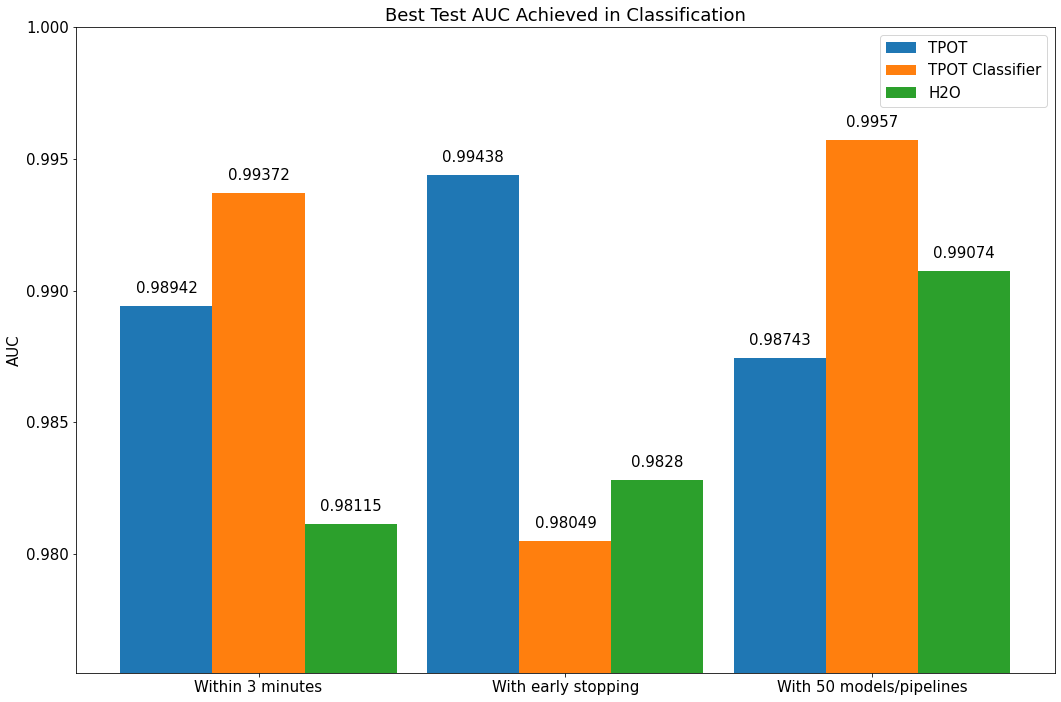

In [9]:
plot_scores(x, width, classification_scores, "classification", "test_plots/auc.png")

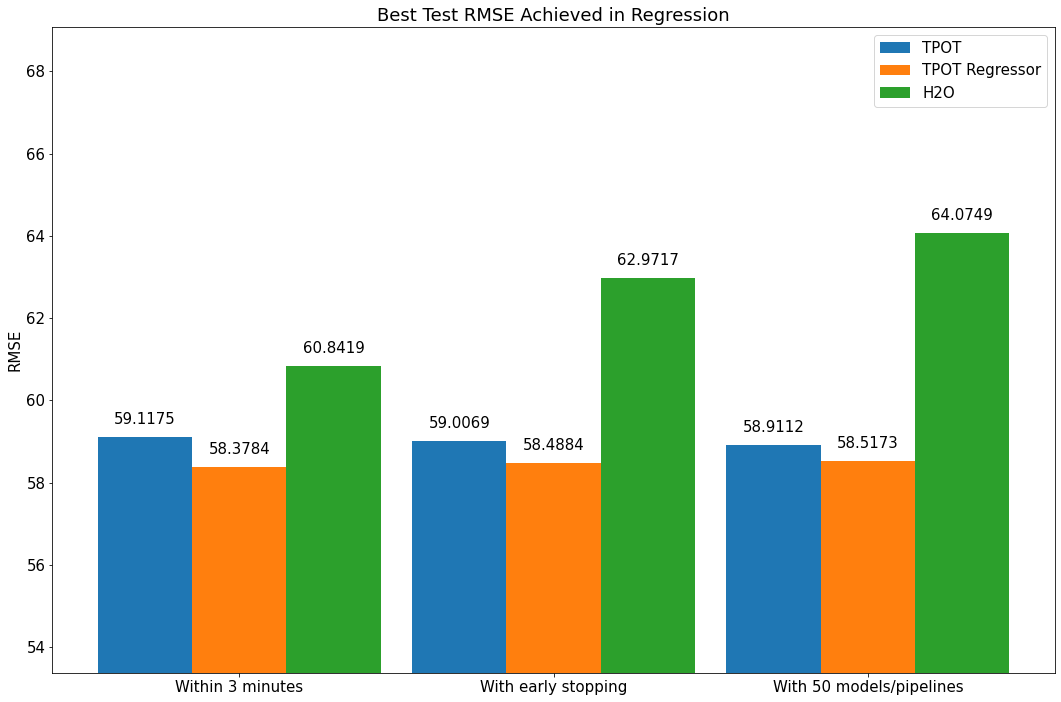

In [10]:
plot_scores(x, width, regression_scores, "regression", "test_plots/rmse.png")

In [11]:
# Function for plotting times
def plot_times(x, width, times, mode, save_dir):
    # Creating a figure and an ax
    fig, ax = plt.subplots()
    
    if mode == "classification":
        tpot_label = "Classifier"
    if mode == "regression":
        tpot_label = "Regressor"
    
    # Plotting times
    tpot_score = ax.bar(x - width, times["TPOT"], width, label="TPOT")
    tpot_cls_reg_score = score = ax.bar(x, times["TPOT (classifier/regressor only)"], width, label=f"TPOT {tpot_label}")
    tpot_h2o_score = ax.bar(x + width, times["H2O"], width, label="H2O")   
    
    # Setting ax title, ylabel, xticks, and xticklabels
    ax.set_title(f"Training Times in Minutes for {mode.capitalize()}")
    ax.set_ylabel("Minutes")
    ax.set_xticks(x)
    ax.set_xticklabels(["Within 3 minutes", "With early stopping", "With 50 models/pipelines"])

    # Setting the ylim based on provided times
    ylim = [np.max((0, times.min().min() - 50)), times.max().max() + 20]
    ax.set_ylim(ylim)

    # Plotting times
    ax.bar_label(tpot_score, padding=10)
    ax.bar_label(tpot_cls_reg_score, padding=10)
    ax.bar_label(tpot_h2o_score, padding=10)

    # Calling a legend
    ax.legend()

    # Adjusting subplot params to make the ax cleaner
    fig.tight_layout()
    
    # Saving the plot
    plt.savefig(save_dir)
    
    # Showing the plot
    plt.show()

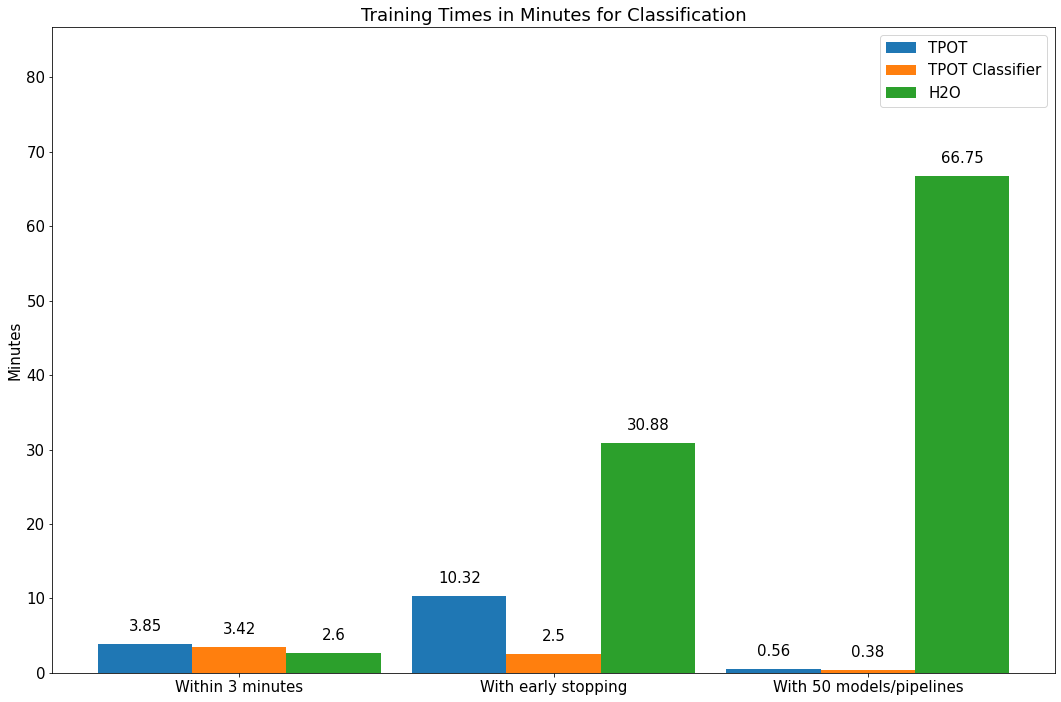

In [12]:
plot_times(x, width, classification_times, "classification", "test_plots/class_time.png")

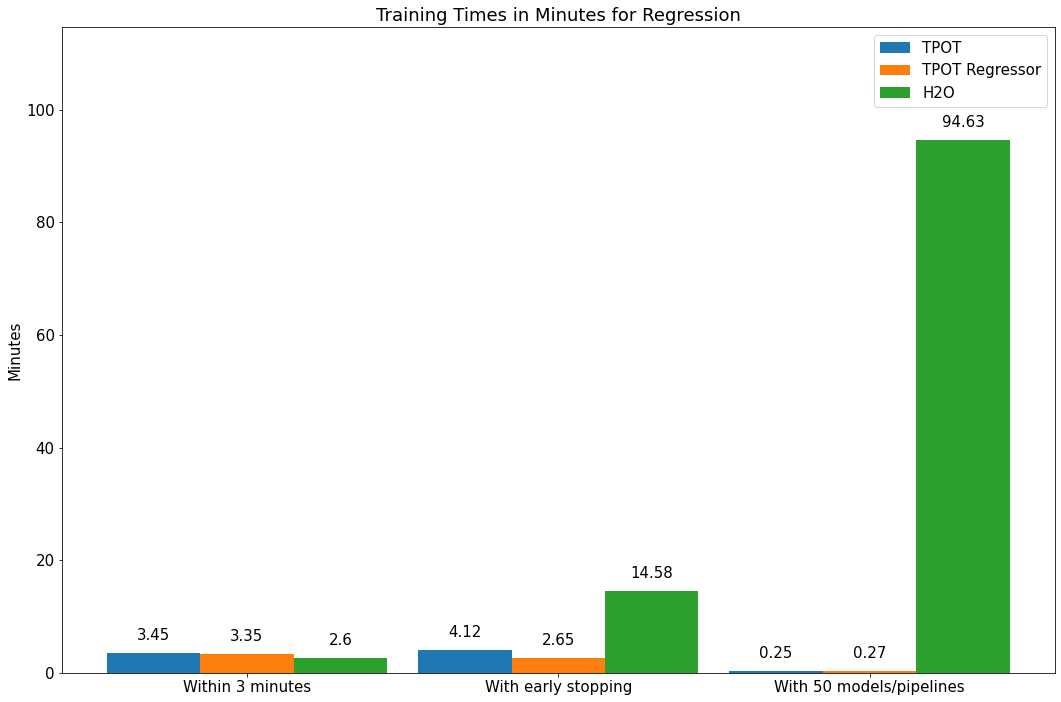

In [13]:
plot_times(x, width, regression_times, "regression",  "test_plots/regr_time.png")